# Project 2: part2

## Import libraries

In [1]:
from pymonntorch import *
import torch

import matplotlib.pyplot as plt

from models.activity import ActivityRecorder
from models.dendrites import Dendrite
from models.currents import ConstantCurrent, NoisyCurrent, SetCurrent, CurrentSum, RandomCurrent
from models.neurons import LIF, ELIF, AELIF
from models.synapses import SimpleSynapse, FullyConnectedSynapse, RandomConnectedFixedProbSynapse, \
    RandomConnectedFixedInputSynapse
from models.time_res import TimeResolution
from simulate import Simulation

In [2]:
def plot_neuron_activity(net, ng_name, title, info_text=None):

    fig, axs = plt.subplots(3, 2, figsize=(18, 8), sharex=True)

    # Plot the membrane potential(voltage)
    axs[0, 0].plot(net[f"{ng_name}_rec", 0].variables["u"][:, :])
    axs[0, 0].axhline(y=net.NeuronGroups[0].behavior[5].init_kwargs['threshold'], color='red', linestyle='--', label=f"{ng_name} Threshold")
    axs[0, 0].set_xlabel('t')
    axs[0, 0].set_ylabel('U(t)')
    axs[0, 0].legend()
    axs[0, 0].set_title('Membrane Potential')

    # Plot the current
    axs[1, 0].plot(net[f"{ng_name}_rec", 0].variables["I"][:, :])
    axs[1, 0].set_xlabel('t')
    axs[1, 0].set_ylabel('I(t)')
    axs[1, 0].legend()
    axs[1, 0].set_title('Current')

    # Plot the raster plot
    spike_events = net[f"{ng_name}_event", 0].variables["spike"]
    spike_times = spike_events[:, 0]
    neuron_ids = spike_events[:, 1]
    axs[0, 1].scatter(spike_times, neuron_ids, s=5)
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('Neuron ID')
    axs[0, 1].legend()
    axs[0, 1].set_title('Raster Plot for LIF model')

    # Plot the activity
    axs[1, 1].plot(net[f"{ng_name}_rec", 0].variables["activity"])
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('activity')
    axs[1, 1].legend()
    axs[1, 1].set_title('Activity')

    # Additional subplot for text and information
    axs[2, 0].axis('off')  # Turn off the axis for this subplot
    axs[2, 1].axis('off')
    axs[2, 0].text(0.1, 0.5, info_text, bbox=dict(facecolor='white', alpha=0.5))

    fig.suptitle(title, fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_weight_distribution(weight_matrix, bins=50, density=True):
    # Flatten the weight matrix into a 1D array
    weights_flat = weight_matrix.flatten()

    # Plot the distribution using a histogram
    plt.hist(weights_flat, bins=bins, density=density, alpha=0.7, color='b')
    plt.title('Weight Matrix Distribution')
    plt.xlabel('Weight Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()



# Part 2: Implementing 3 synapses connectivity schemes

The 3 synapses connectivity schemes has been implemented in synapses model, here we just use and experiment them with examples.

We have experimented the fully connected scheme in the part1, based on the goal of this part, here we focus more in the synapse parameters. we begin with a simple one population synapse:

# 1- Fully connected synapses

## 1.1 Inside one neuron group synapse:
We saw the behavior of the population when there is no noise or randomness in neurons; Now we change parameters of synapse to see results. For example, we test the population with a low variance(5% of the weights), normal variance(25% of the weights), high variance(50% of the weights) and extremely high variance(100% of the weights).

### 1.1.1 Change in j0

In [3]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc1 = sim.add_neuron_group(
    tag="ng_exc1",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.6),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc1_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc1_event")
    }
)
ng_exc2 = sim.add_neuron_group(
    tag="ng_exc2",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.6),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc2_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc2_event")
    }
)
ng_exc3 = sim.add_neuron_group(
    tag="ng_exc3",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.6),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc3_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc3_event")
    }
)
syn_exc1 = sim.add_synapse_group(
                   tag="exc1-exc1",
                   src=ng_exc1,
                   dst=ng_exc1,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.25)})
syn_exc2 = sim.add_synapse_group(
                   tag="exc2-exc2",
                   src=ng_exc2,
                   dst=ng_exc2,
                   behavior={3: FullyConnectedSynapse(j0=25, variance=0.25)})
syn_exc3 = sim.add_synapse_group(
                   tag="exc3-exc3",
                   src=ng_exc3,
                   dst=ng_exc3,
                   behavior={3: FullyConnectedSynapse(j0=50, variance=0.25)})
sim.simulate(iterations=300)

Network['Network_1', 'Network'](Neurons: tensor(300)|3 groups, Synapses: tensor(30000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc1', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.6,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_event,)}
NeuronGroup['ng_exc2', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.6,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annot

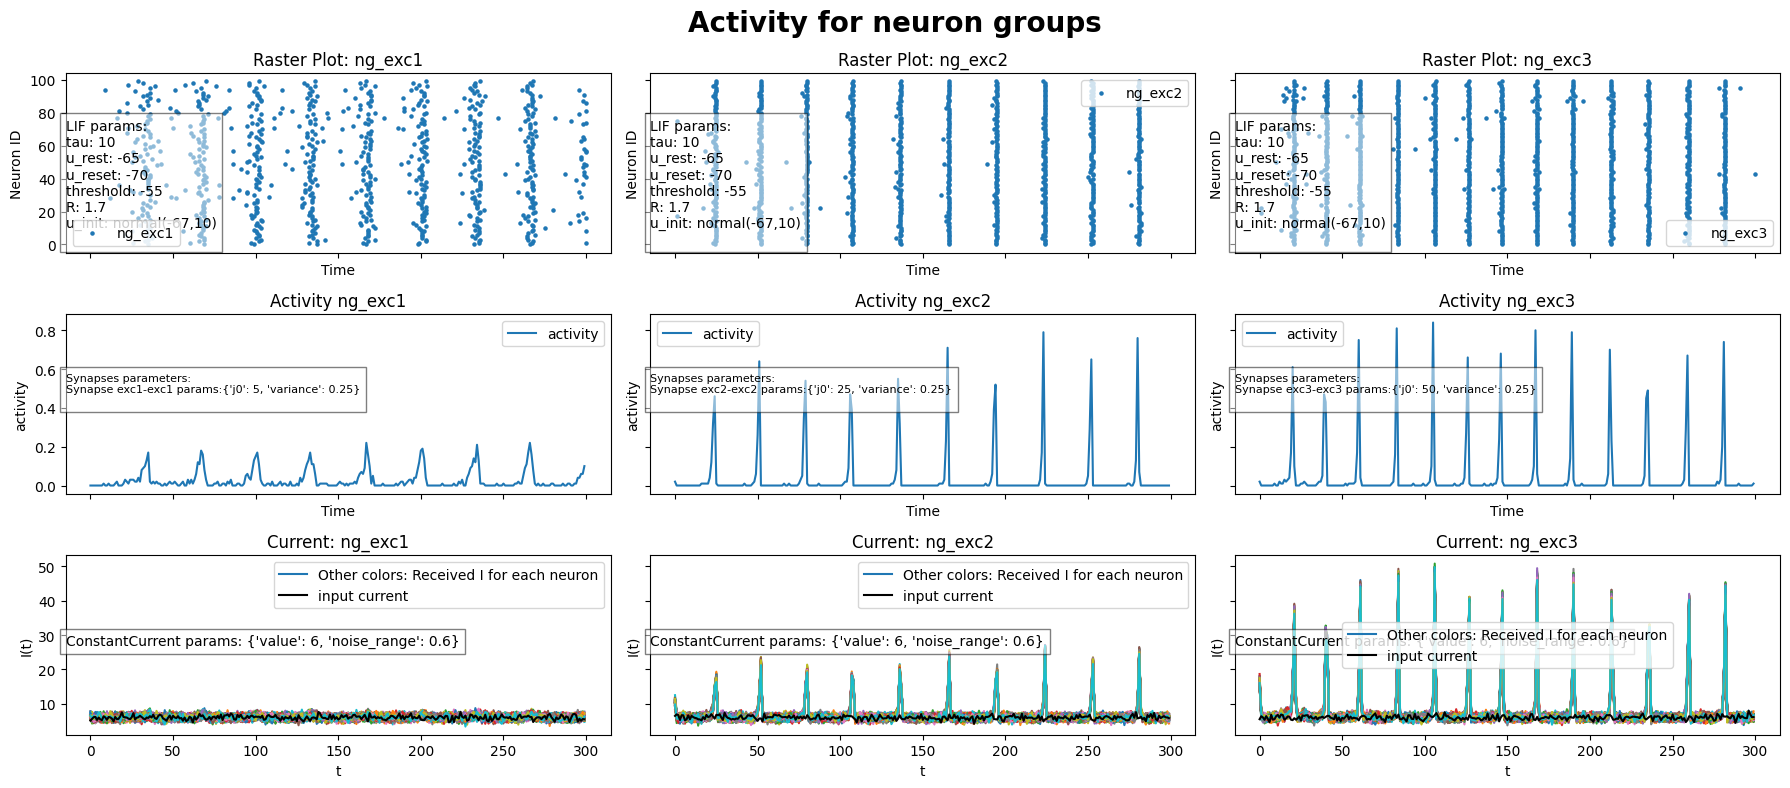

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
# Raster plot:
ng_exc1.add_raster_plot(axs[0, 0])
ng_exc1.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc2.add_raster_plot(axs[0, 1])
ng_exc2.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_exc3.add_raster_plot(axs[0, 2])
ng_exc3.add_neuron_model_params_info(axs[0, 2], model_idx=7)

ng_exc1.add_activity_plot(axs[1, 0])
syn_exc1.add_synapses_params_info(axs[1, 0], synapse_idx=3)
ng_exc2.add_activity_plot(axs[1, 1])
syn_exc2.add_synapses_params_info(axs[1, 1], synapse_idx=3)
ng_exc3.add_activity_plot(axs[1, 2])
syn_exc3.add_synapses_params_info(axs[1, 2], synapse_idx=3)

ng_exc1.add_current_plot(axs[2, 0])
ng_exc1.add_current_params_info(axs[2, 0], current_idx=2, text_y=0.5)
ng_exc2.add_current_plot(axs[2, 1])
ng_exc1.add_current_params_info(axs[2, 1], current_idx=2, text_y=0.5)
ng_exc3.add_current_plot(axs[2, 2])
ng_exc1.add_current_params_info(axs[2, 2], current_idx=2, text_y=0.5)
fig.suptitle("Activity for neuron groups", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-one-ng-full-synapse-diff-j.pdf")
plt.show()

As we see, beside the fact that all neurons are the same at the begining, when we increase the variance of weights, the time of spikes of neurons will be different.

### Random current

In [5]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc1 = sim.add_neuron_group(
    tag="ng_exc1",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc1_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc1_event")
    }
)
ng_exc2 = sim.add_neuron_group(
    tag="ng_exc2",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc2_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc2_event")
    }
)
ng_exc3 = sim.add_neuron_group(
    tag="ng_exc3",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: RandomCurrent(mean=6, std=2),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc3_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc3_event")
    }
)
syn_exc1 = sim.add_synapse_group(
                   tag="exc1-exc1",
                   src=ng_exc1,
                   dst=ng_exc1,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.25)})
syn_exc2 = sim.add_synapse_group(
                   tag="exc2-exc2",
                   src=ng_exc2,
                   dst=ng_exc2,
                   behavior={3: FullyConnectedSynapse(j0=25, variance=0.25)})
syn_exc3 = sim.add_synapse_group(
                   tag="exc3-exc3",
                   src=ng_exc3,
                   dst=ng_exc3,
                   behavior={3: FullyConnectedSynapse(j0=50, variance=0.25)})
sim.simulate(iterations=300)

Network['Network_1', 'Network'](Neurons: tensor(300)|3 groups, Synapses: tensor(30000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc1', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:RandomCurrent(mean=6,std=2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_event,)}
NeuronGroup['ng_exc2', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:RandomCurrent(mean=6,std=2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_event

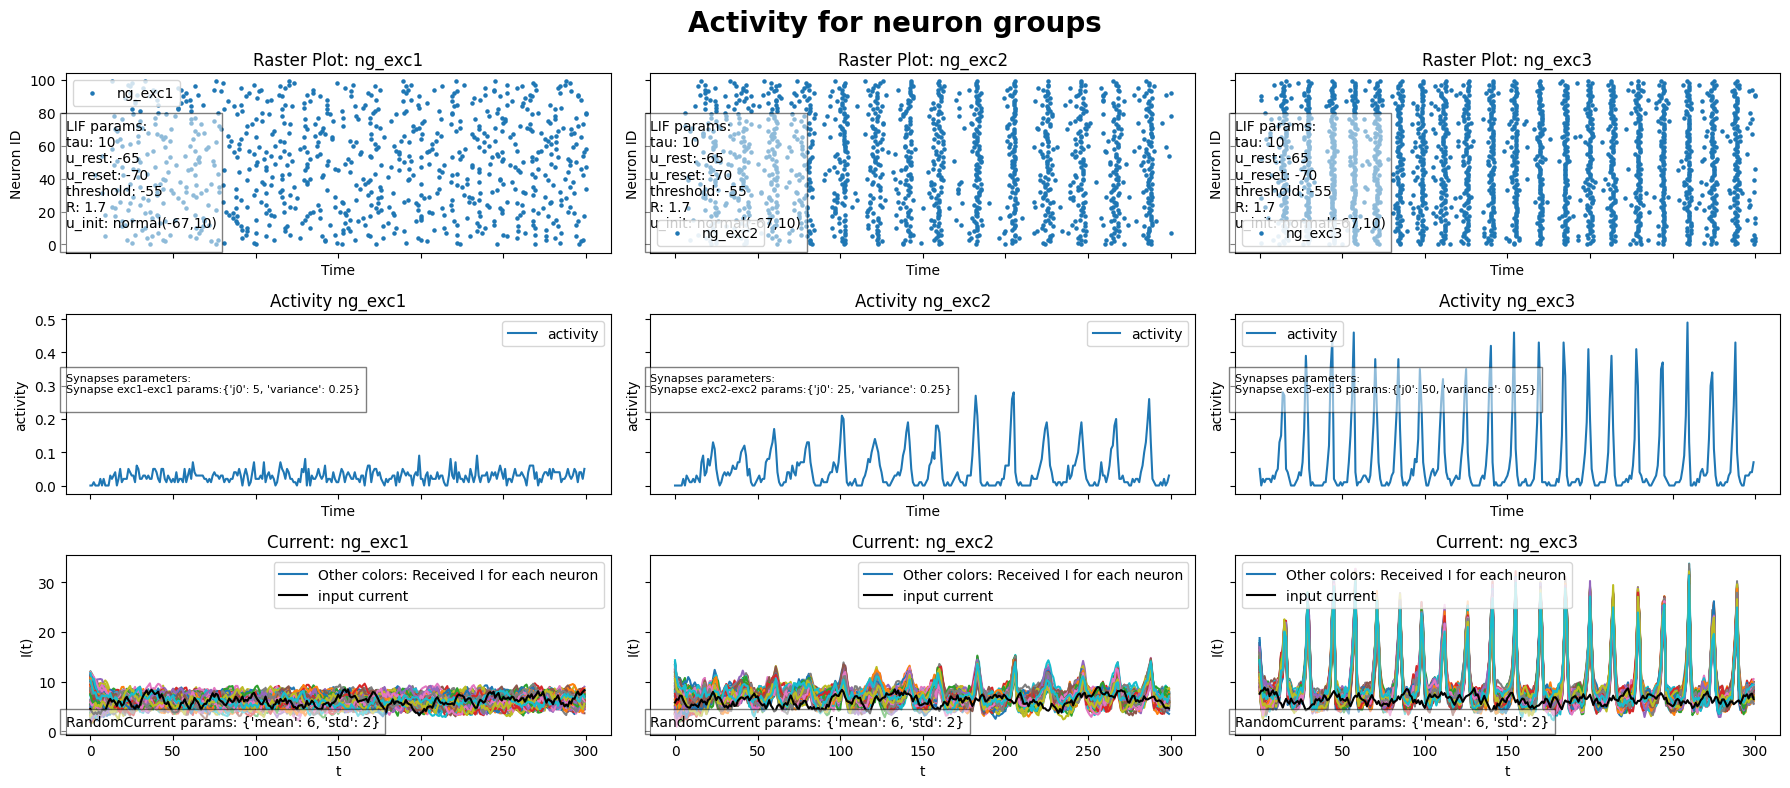

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
# Raster plot:
ng_exc1.add_raster_plot(axs[0, 0])
ng_exc1.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc2.add_raster_plot(axs[0, 1])
ng_exc2.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_exc3.add_raster_plot(axs[0, 2])
ng_exc3.add_neuron_model_params_info(axs[0, 2], model_idx=7)

ng_exc1.add_activity_plot(axs[1, 0])
syn_exc1.add_synapses_params_info(axs[1, 0], synapse_idx=3)
ng_exc2.add_activity_plot(axs[1, 1])
syn_exc2.add_synapses_params_info(axs[1, 1], synapse_idx=3)
ng_exc3.add_activity_plot(axs[1, 2])
syn_exc3.add_synapses_params_info(axs[1, 2], synapse_idx=3)

ng_exc1.add_current_plot(axs[2, 0])
ng_exc1.add_current_params_info(axs[2, 0], current_idx=2)
ng_exc2.add_current_plot(axs[2, 1])
ng_exc1.add_current_params_info(axs[2, 1], current_idx=2)
ng_exc3.add_current_plot(axs[2, 2])
ng_exc1.add_current_params_info(axs[2, 2], current_idx=2)
fig.suptitle("Activity for neuron groups", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-one-ng-full-synapse-diff-j-rand-curr.pdf")
plt.show()

### 1.1.2 Change in variance

Noisy constant current

In [7]:
sim = Simulation(net=Network(behavior={0: TimeResolution(dt=1.0,)}),)
ng_exc1 = sim.add_neuron_group(
    tag="ng_exc1",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.6),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc1_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc1_event")
    }
)
ng_exc2 = sim.add_neuron_group(
    tag="ng_exc2",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.6),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc2_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc2_event")
    }
)
ng_exc3 = sim.add_neuron_group(
    tag="ng_exc3",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.6),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc3_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc3_event")
    }
)
syn_exc1 = sim.add_synapse_group(
                   tag="exc1-exc1",
                   src=ng_exc1,
                   dst=ng_exc1,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.1)})
syn_exc2 = sim.add_synapse_group(
                   tag="exc2-exc2",
                   src=ng_exc2,
                   dst=ng_exc2,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.50)})
syn_exc3 = sim.add_synapse_group(
                   tag="exc3-exc3",
                   src=ng_exc3,
                   dst=ng_exc3,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.9)})
sim.simulate(iterations=300)

Network['Network_1', 'Network'](Neurons: tensor(300)|3 groups, Synapses: tensor(30000)|3 groups){0:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc1', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.6,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_event,)}
NeuronGroup['ng_exc2', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.6,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annot

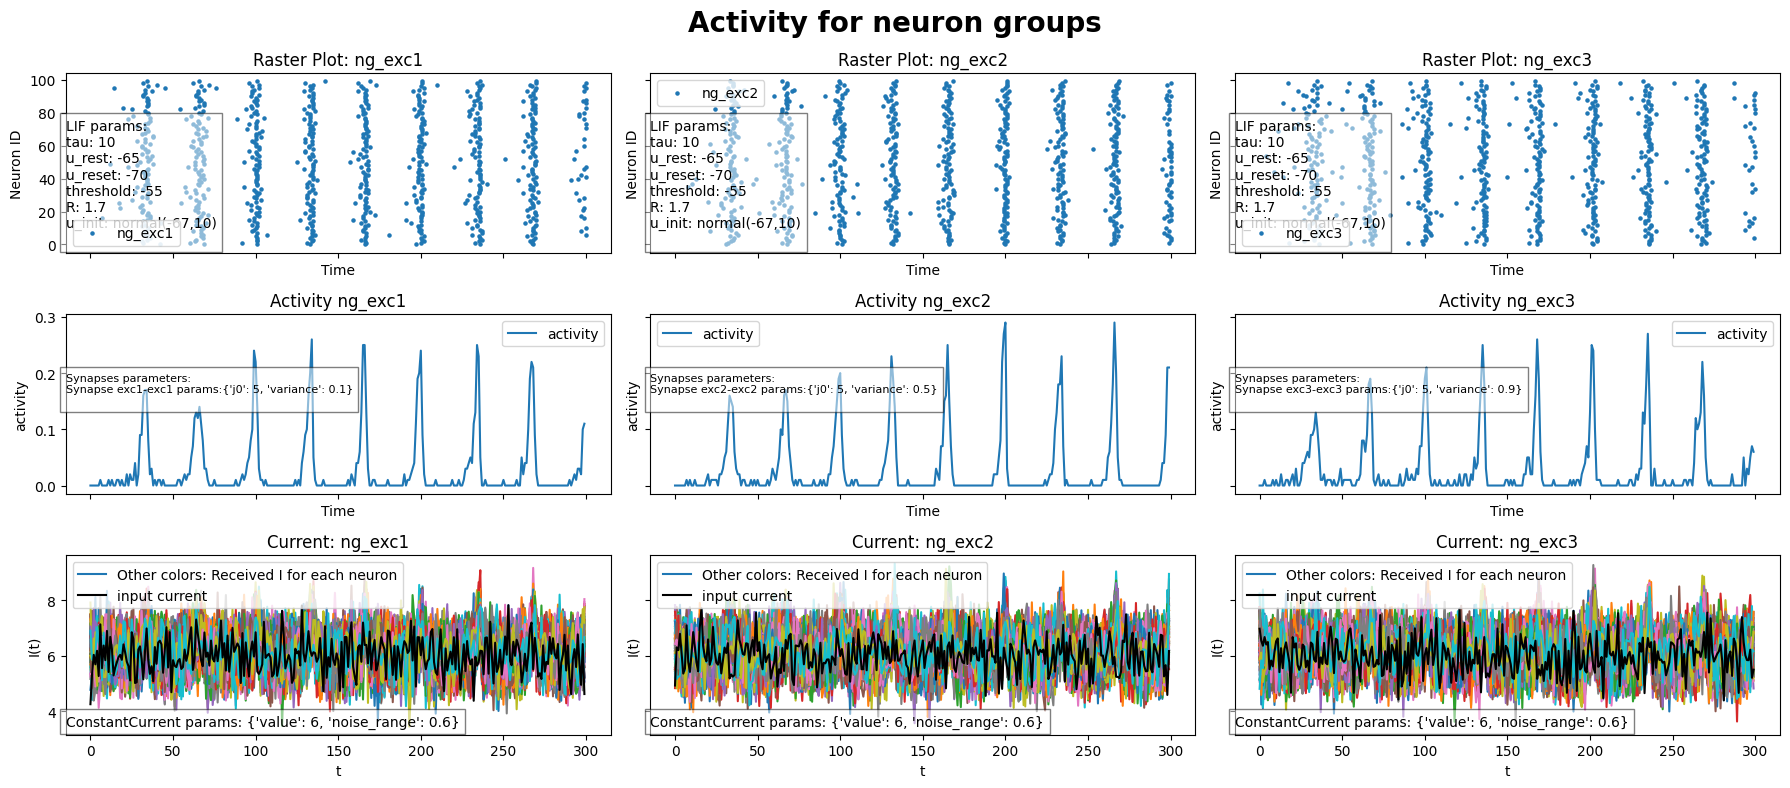

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
# Raster plot:
ng_exc1.add_raster_plot(axs[0, 0])
ng_exc1.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc2.add_raster_plot(axs[0, 1])
ng_exc2.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_exc3.add_raster_plot(axs[0, 2])
ng_exc3.add_neuron_model_params_info(axs[0, 2], model_idx=7)

ng_exc1.add_activity_plot(axs[1, 0])
syn_exc1.add_synapses_params_info(axs[1, 0], synapse_idx=3)
ng_exc2.add_activity_plot(axs[1, 1])
syn_exc2.add_synapses_params_info(axs[1, 1], synapse_idx=3)
ng_exc3.add_activity_plot(axs[1, 2])
syn_exc3.add_synapses_params_info(axs[1, 2], synapse_idx=3)

ng_exc1.add_current_plot(axs[2, 0])
ng_exc1.add_current_params_info(axs[2, 0], current_idx=2)
ng_exc2.add_current_plot(axs[2, 1])
ng_exc1.add_current_params_info(axs[2, 1], current_idx=2)
ng_exc3.add_current_plot(axs[2, 2])
ng_exc1.add_current_params_info(axs[2, 2], current_idx=2)
fig.suptitle("Activity for neuron groups", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-one-ng-full-synapse-diff-variance.pdf")
plt.show()

### random current

In [9]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc1 = sim.add_neuron_group(
    tag="ng_exc1",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: RandomCurrent(mean=6, std=0.5),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc1_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc1_event")
    }
)
ng_exc2 = sim.add_neuron_group(
    tag="ng_exc2",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: RandomCurrent(mean=6, std=0.5),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc2_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc2_event")
    }
)
ng_exc3 = sim.add_neuron_group(
    tag="ng_exc3",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: RandomCurrent(mean=6, std=0.5),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc3_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc3_event")
    }
)
syn_exc1 = sim.add_synapse_group(
                   tag="exc1-exc1",
                   src=ng_exc1,
                   dst=ng_exc1,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.05)})
syn_exc2 = sim.add_synapse_group(
                   tag="exc2-exc2",
                   src=ng_exc2,
                   dst=ng_exc2,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.5)})
syn_exc3 = sim.add_synapse_group(
                   tag="exc3-exc3",
                   src=ng_exc3,
                   dst=ng_exc3,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=1)})
sim.simulate(iterations=300)

Network['Network_1', 'Network'](Neurons: tensor(300)|3 groups, Synapses: tensor(30000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc1', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:RandomCurrent(mean=6,std=0.5,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_event,)}
NeuronGroup['ng_exc2', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:RandomCurrent(mean=6,std=0.5,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_e

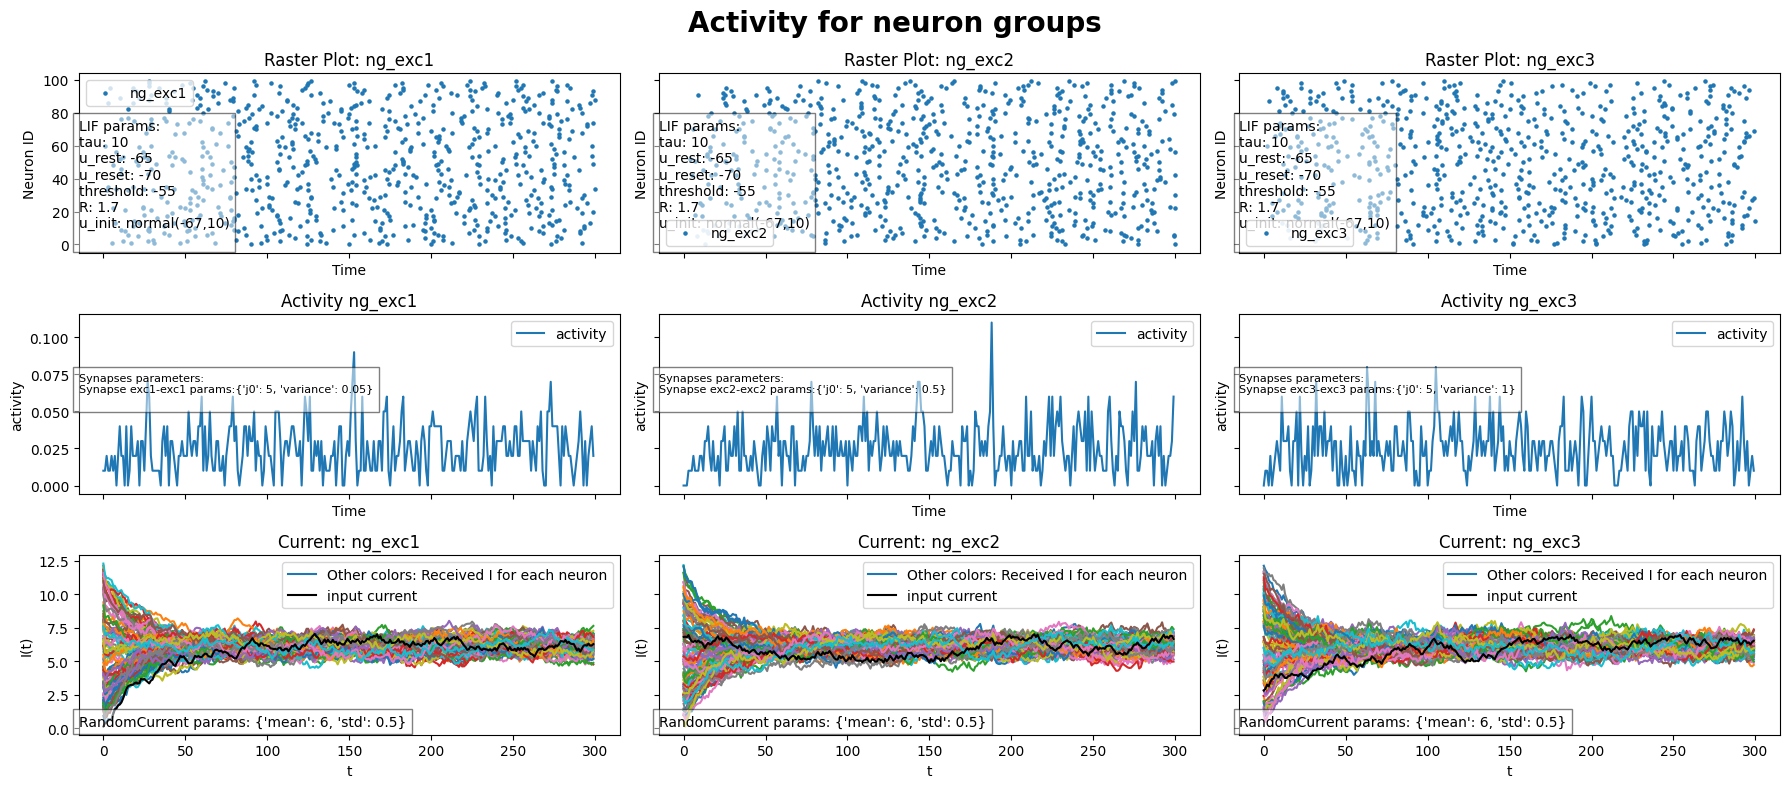

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
# Raster plot:
ng_exc1.add_raster_plot(axs[0, 0])
ng_exc1.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc2.add_raster_plot(axs[0, 1])
ng_exc2.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_exc3.add_raster_plot(axs[0, 2])
ng_exc3.add_neuron_model_params_info(axs[0, 2], model_idx=7)

ng_exc1.add_activity_plot(axs[1, 0])
syn_exc1.add_synapses_params_info(axs[1, 0], synapse_idx=3)
ng_exc2.add_activity_plot(axs[1, 1])
syn_exc2.add_synapses_params_info(axs[1, 1], synapse_idx=3)
ng_exc3.add_activity_plot(axs[1, 2])
syn_exc3.add_synapses_params_info(axs[1, 2], synapse_idx=3)

ng_exc1.add_current_plot(axs[2, 0])
ng_exc1.add_current_params_info(axs[2, 0], current_idx=2)
ng_exc2.add_current_plot(axs[2, 1])
ng_exc1.add_current_params_info(axs[2, 1], current_idx=2)
ng_exc3.add_current_plot(axs[2, 2])
ng_exc1.add_current_params_info(axs[2, 2], current_idx=2)
fig.suptitle("Activity for neuron groups", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-one-ng-full-synapse-diff-variance-rand-curr.pdf")
plt.show()

### Size of ng

#### COnstant and noisy current

In [11]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc1 = sim.add_neuron_group(
    tag="ng_exc1",
    size=50,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.5),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc1_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc1_event")
    }
)
ng_exc2 = sim.add_neuron_group(
    tag="ng_exc2",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.5),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc2_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc2_event")
    }
)
ng_exc3 = sim.add_neuron_group(
    tag="ng_exc3",
    size=250,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.5),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc3_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc3_event")
    }
)
syn_exc1 = sim.add_synapse_group(
                   tag="exc1-exc1",
                   src=ng_exc1,
                   dst=ng_exc1,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.25)})
syn_exc2 = sim.add_synapse_group(
                   tag="exc2-exc2",
                   src=ng_exc2,
                   dst=ng_exc2,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.25)})
syn_exc3 = sim.add_synapse_group(
                   tag="exc3-exc3",
                   src=ng_exc3,
                   dst=ng_exc3,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.25)})
sim.simulate(iterations=300)

Network['Network_1', 'Network'](Neurons: tensor(400)|3 groups, Synapses: tensor(75000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc1', 'CustomNeuronGroup', 'ng'](50){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.5,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_event,)}
NeuronGroup['ng_exc2', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.5,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annota

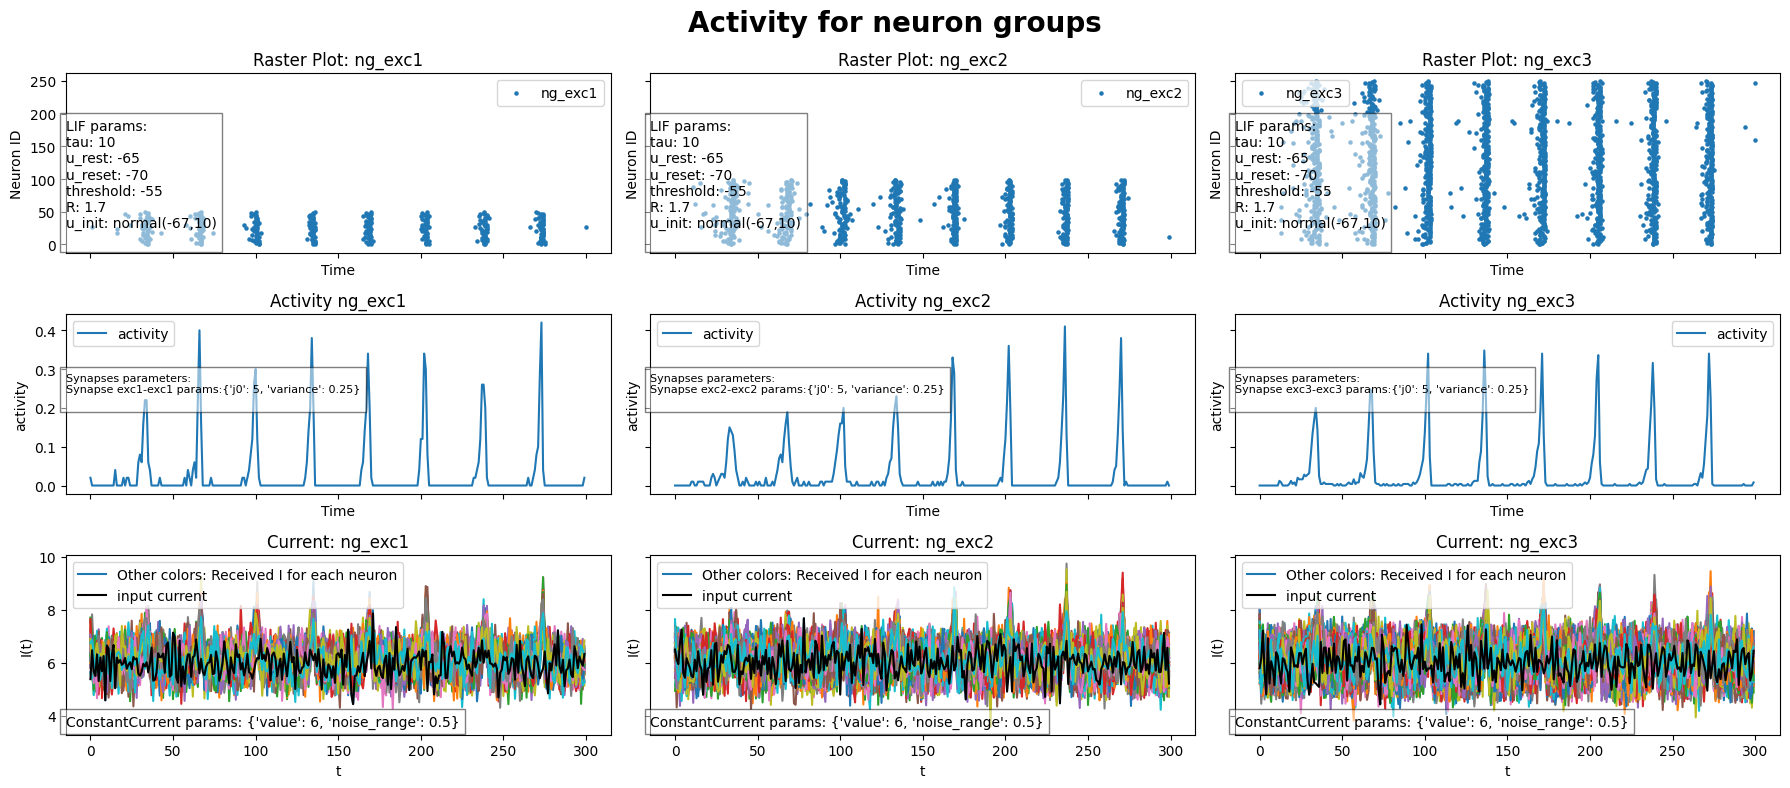

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
# Raster plot:
ng_exc1.add_raster_plot(axs[0, 0])
ng_exc1.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc2.add_raster_plot(axs[0, 1])
ng_exc2.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_exc3.add_raster_plot(axs[0, 2])
ng_exc3.add_neuron_model_params_info(axs[0, 2], model_idx=7)

ng_exc1.add_activity_plot(axs[1, 0])
syn_exc1.add_synapses_params_info(axs[1, 0], synapse_idx=3)
ng_exc2.add_activity_plot(axs[1, 1])
syn_exc2.add_synapses_params_info(axs[1, 1], synapse_idx=3)
ng_exc3.add_activity_plot(axs[1, 2])
syn_exc3.add_synapses_params_info(axs[1, 2], synapse_idx=3)

ng_exc1.add_current_plot(axs[2, 0])
ng_exc1.add_current_params_info(axs[2, 0], current_idx=2)
ng_exc2.add_current_plot(axs[2, 1])
ng_exc1.add_current_params_info(axs[2, 1], current_idx=2)
ng_exc3.add_current_plot(axs[2, 2])
ng_exc1.add_current_params_info(axs[2, 2], current_idx=2)
fig.suptitle("Activity for neuron groups", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-one-ng-full-synapse-diff-size.pdf")
plt.show()

#### Different neuron models:

In [13]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc1 = sim.add_neuron_group(
    tag="LIF",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.5),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="LIF_rec"),
        10: EventRecorder(variables=['spike'], tag="LIF_event")
    }
)
ng_exc2 = sim.add_neuron_group(
    tag="ELIF",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=13.8, noise_range=0.5),
        6: Dendrite(),
        7: ELIF(R=1.7,
                tau=10,
                threshold=-13,
                rh_threshold=-42,
                u_rest=-65,
                u_reset=-73,
                delta_T=0.1
                ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ELIF_rec"),
        10: EventRecorder(variables=['spike'], tag="ELIF_event")
    }
)
ng_exc3 = sim.add_neuron_group(
    tag="AELIF",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=30, noise_range=0.5),
        6: Dendrite(),
        7: AELIF(a=0.5,
                 b=7,
                 R=1.7,
                 tau_m=10,
                 tau_w=100,
                 threshold=-13,
                 rh_threshold=-42,
                 u_rest=-65,
                 u_reset=-73,
                 delta_T=0.1
                 ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="AELIF_rec"),
        10: EventRecorder(variables=['spike'], tag="AELIF_event")
    }
)
syn_exc1 = sim.add_synapse_group(
                   tag="LIF-LIF",
                   src=ng_exc1,
                   dst=ng_exc1,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.25)})
syn_exc2 = sim.add_synapse_group(
                   tag="ELIF-ELIF",
                   src=ng_exc2,
                   dst=ng_exc2,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.25)})
syn_exc3 = sim.add_synapse_group(
                   tag="AELIF-AELIF",
                   src=ng_exc3,
                   dst=ng_exc3,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.25)})
sim.simulate(iterations=300)

Network['Network_1', 'Network'](Neurons: tensor(300)|3 groups, Synapses: tensor(30000)|3 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['LIF', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.5,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=LIF_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=LIF_event,)}
NeuronGroup['ELIF', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=13.8,noise_range=0.5,)6:Dendrite()7:ELIF(R=1.7,tau=10,threshold=-13,rh_threshold=-42,u_rest=-65,u_reset=-73,delta_T=0.1,)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ELIF_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=Tru

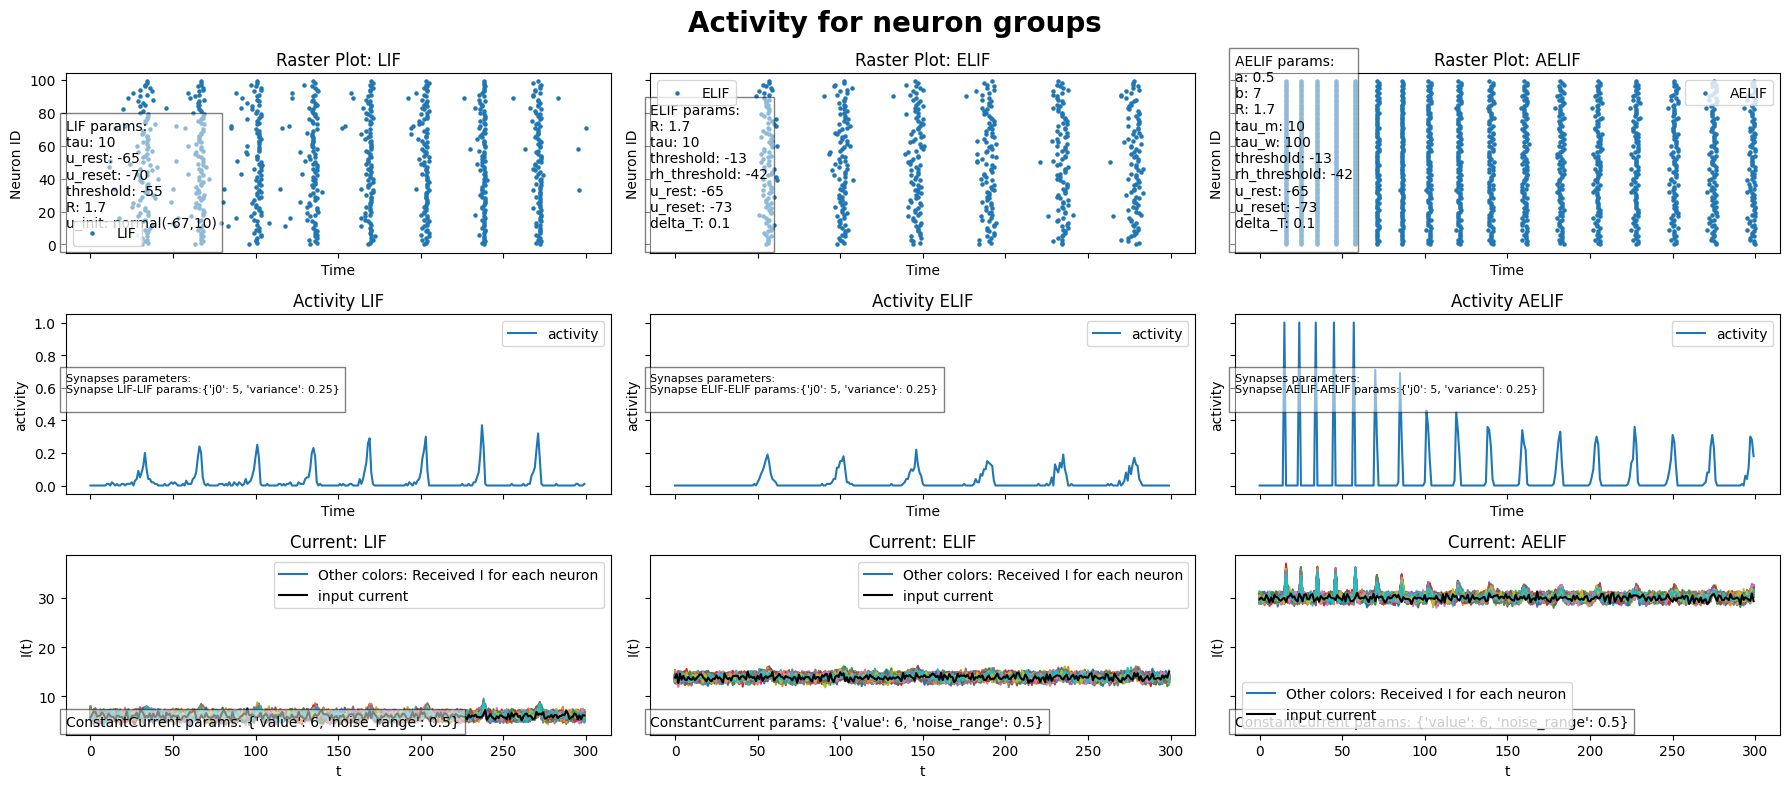

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey='row')
# Raster plot:
ng_exc1.add_raster_plot(axs[0, 0])
ng_exc1.add_neuron_model_params_info(axs[0, 0], model_idx=7)
ng_exc2.add_raster_plot(axs[0, 1])
ng_exc2.add_neuron_model_params_info(axs[0, 1], model_idx=7)
ng_exc3.add_raster_plot(axs[0, 2])
ng_exc3.add_neuron_model_params_info(axs[0, 2], model_idx=7)

ng_exc1.add_activity_plot(axs[1, 0])
syn_exc1.add_synapses_params_info(axs[1, 0], synapse_idx=3)
ng_exc2.add_activity_plot(axs[1, 1])
syn_exc2.add_synapses_params_info(axs[1, 1], synapse_idx=3)
ng_exc3.add_activity_plot(axs[1, 2])
syn_exc3.add_synapses_params_info(axs[1, 2], synapse_idx=3)

ng_exc1.add_current_plot(axs[2, 0])
ng_exc1.add_current_params_info(axs[2, 0], current_idx=2)
ng_exc2.add_current_plot(axs[2, 1])
ng_exc1.add_current_params_info(axs[2, 1], current_idx=2)
ng_exc3.add_current_plot(axs[2, 2])
ng_exc1.add_current_params_info(axs[2, 2], current_idx=2)
fig.suptitle("Activity for neuron groups", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-one-ng-full-synapse-diff-neuron-model.pdf")
plt.show()

## 1.2 Synapse between two groups:
Now let's create a synapse between two groups of neurons. First, we test when there's no noise and all neurons begin with the same membrane potential. Now we change parameters of synapse to see results. For example, we test the population with a low variance(5% of the weights), normal variance(25% of the weights), high variance(50% of the weights) and extremely high variance(100% of the weights).

### 1.2.1 Change in j0

In [23]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc1 = sim.add_neuron_group(
    tag="ng_exc1",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.5),
        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc1_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc1_event")
    }
)
ng_exc2 = sim.add_neuron_group(
    tag="ng_exc2",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.5),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc2_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc2_event")
    }
)
syn_exc1_exc2 = sim.add_synapse_group(
                   tag="exc1-exc2",
                   src=ng_exc1,
                   dst=ng_exc2,
                   behavior={3: FullyConnectedSynapse(j0=15, variance=0.2)})

syn_exc2_exc1 = sim.add_synapse_group(
                   tag="exc2-exc1",
                   src=ng_exc2,
                   dst=ng_exc1,
                   behavior={3: FullyConnectedSynapse(j0=15, variance=0.2)})
sim.simulate(iterations=300)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(20000)|2 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc1', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.5,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_event,)}
NeuronGroup['ng_exc2', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.5,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annot

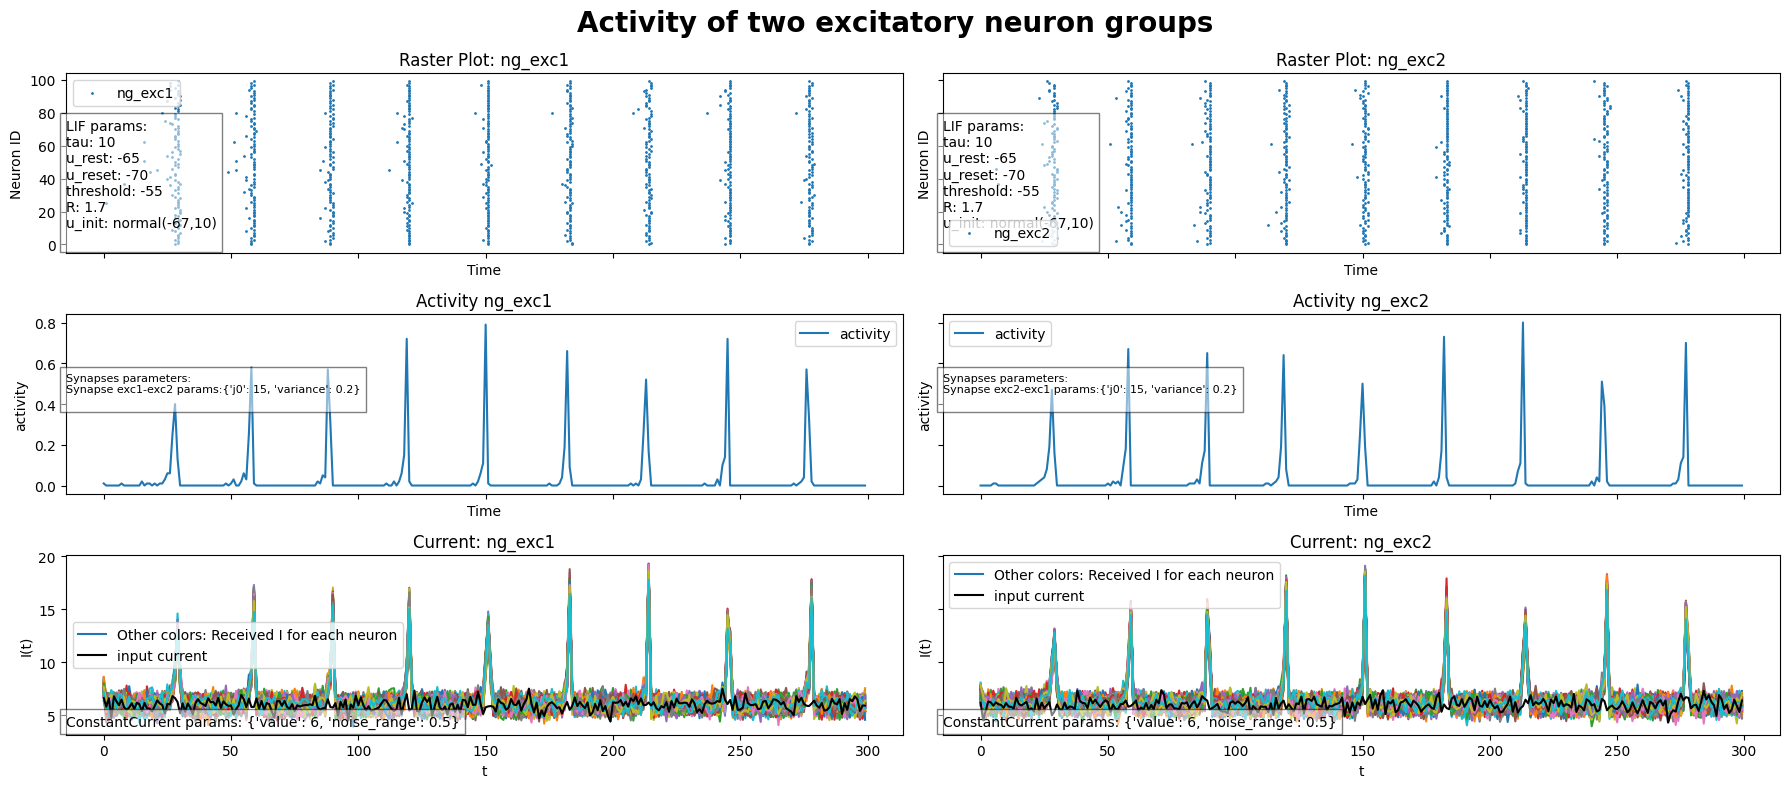

In [24]:
fig, axs = plt.subplots(3, 2, figsize=(18, 8), sharex=True, sharey='row')
# Raster plot for ng1:
ng_exc1.add_raster_plot(axs[0, 0], s=1)
ng_exc1.add_neuron_model_params_info(axs[0, 0], model_idx=7)
# Raster plot for ng2:
ng_exc2.add_raster_plot(axs[0, 1], s=1)
ng_exc2.add_neuron_model_params_info(axs[0, 1], model_idx=7)

# Activity plot for ng1:
ng_exc1.add_activity_plot(axs[1, 0])
syn_exc1_exc2.add_synapses_params_info(axs[1, 0], synapse_idx=3)
# Activity plot for ng2:
ng_exc2.add_activity_plot(axs[1, 1])
syn_exc2_exc1.add_synapses_params_info(axs[1, 1], synapse_idx=3)

# Current plot for ng1:
ng_exc1.add_current_plot(axs[2, 0])
ng_exc2.add_current_params_info(axs[2, 0], current_idx=2)
# Current plot for ng2:
ng_exc2.add_current_plot(axs[2, 1])
ng_exc2.add_current_params_info(axs[2, 1], current_idx=2)


fig.suptitle("Activity of two excitatory neuron groups", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-two-ng-full-synapse-noise-curr.pdf")
plt.show()

#### random curr

In [25]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc1 = sim.add_neuron_group(
    tag="ng_exc1",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: RandomCurrent(mean=6, std=0.2),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc1_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc1_event")
    }
)
ng_exc2 = sim.add_neuron_group(
    tag="ng_exc2",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: RandomCurrent(mean=6, std=0.2),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc2_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc2_event")
    }
)
syn_exc1_exc2 = sim.add_synapse_group(
                   tag="exc1-exc2",
                   src=ng_exc1,
                   dst=ng_exc2,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.2)})

syn_exc2_exc1 = sim.add_synapse_group(
                   tag="exc2-exc1",
                   src=ng_exc2,
                   dst=ng_exc1,
                   behavior={3: FullyConnectedSynapse(j0=5, variance=0.2)})
sim.simulate(iterations=300)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(20000)|2 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc1', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:RandomCurrent(mean=6,std=0.2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_event,)}
NeuronGroup['ng_exc2', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:RandomCurrent(mean=6,std=0.2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_e

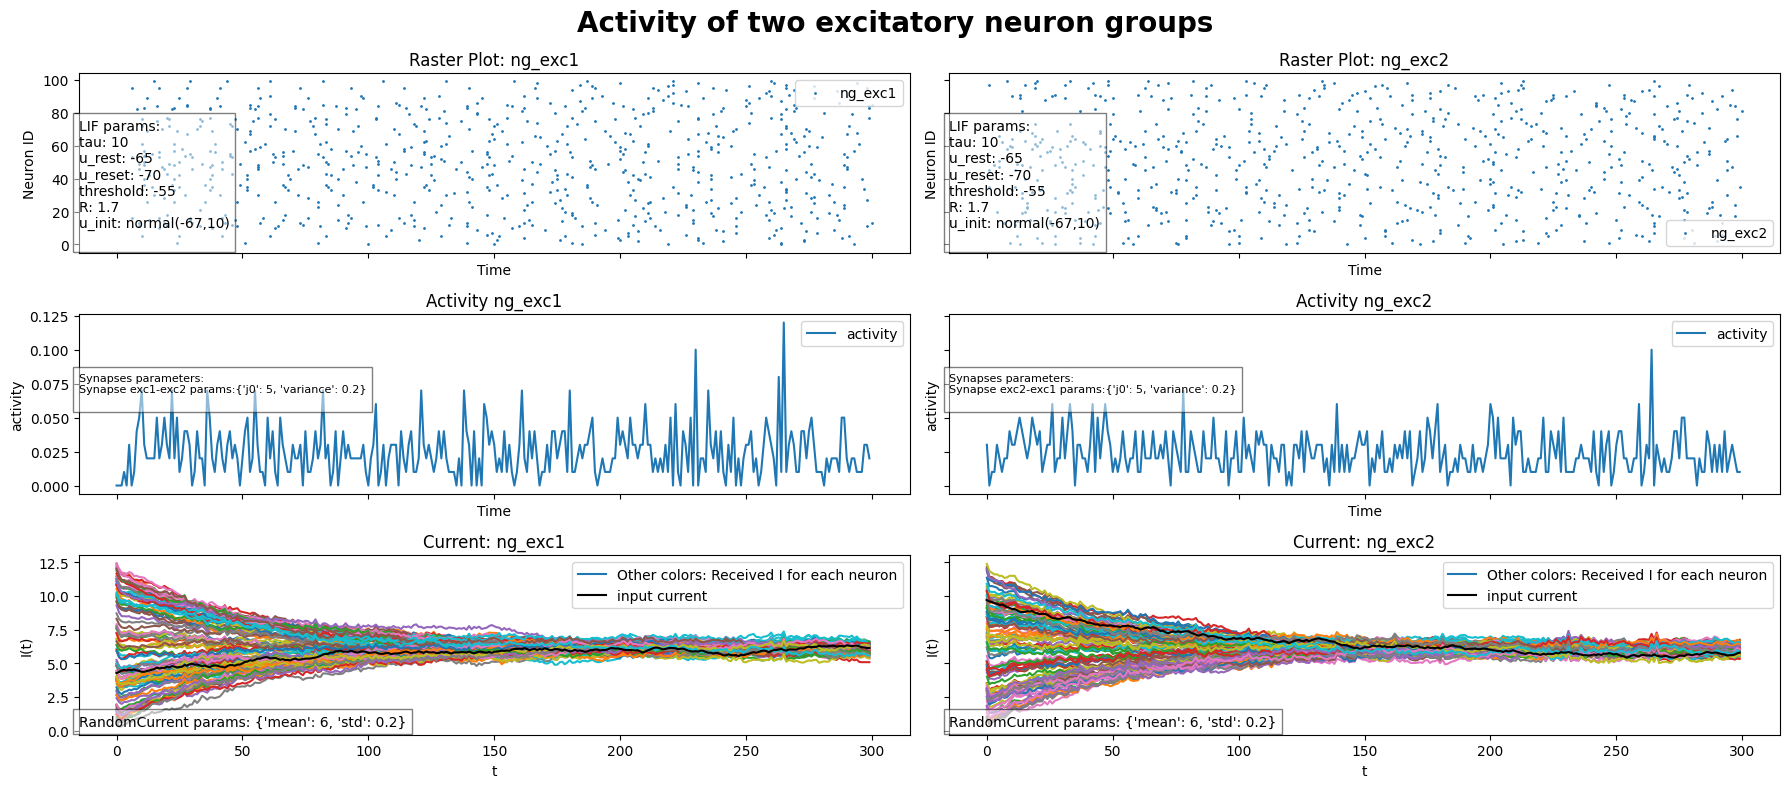

In [26]:
fig, axs = plt.subplots(3, 2, figsize=(18, 8), sharex=True, sharey='row')
# Raster plot for ng1:
ng_exc1.add_raster_plot(axs[0, 0], s=1)
ng_exc1.add_neuron_model_params_info(axs[0, 0], model_idx=7)
# Raster plot for ng2:
ng_exc2.add_raster_plot(axs[0, 1], s=1)
ng_exc2.add_neuron_model_params_info(axs[0, 1], model_idx=7)

# Activity plot for ng1:
ng_exc1.add_activity_plot(axs[1, 0])
syn_exc1_exc2.add_synapses_params_info(axs[1, 0], synapse_idx=3)
# Activity plot for ng2:
ng_exc2.add_activity_plot(axs[1, 1])
syn_exc2_exc1.add_synapses_params_info(axs[1, 1], synapse_idx=3)

# Current plot for ng1:
ng_exc1.add_current_plot(axs[2, 0])
ng_exc2.add_current_params_info(axs[2, 0], current_idx=2)
# Current plot for ng2:
ng_exc2.add_current_plot(axs[2, 1])
ng_exc2.add_current_params_info(axs[2, 1], current_idx=2)


fig.suptitle("Activity of two excitatory neuron groups", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-two-ng-full-synapse-low-j-rand-curr.pdf")
plt.show()

different j

In [35]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc1 = sim.add_neuron_group(
    tag="ng_exc1",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: RandomCurrent(mean=6, std=0.2),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc1_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc1_event")
    }
)
ng_exc2 = sim.add_neuron_group(
    tag="ng_exc2",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: RandomCurrent(mean=6, std=0.2),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc2_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc2_event")
    }
)
syn_exc1_exc2 = sim.add_synapse_group(
                   tag="exc1-exc2",
                   src=ng_exc1,
                   dst=ng_exc2,
                   behavior={3: FullyConnectedSynapse(j0=100, variance=0.2)})

syn_exc2_exc1 = sim.add_synapse_group(
                   tag="exc2-exc1",
                   src=ng_exc2,
                   dst=ng_exc1,
                   behavior={3: FullyConnectedSynapse(j0=10, variance=0.2)})
sim.simulate(iterations=300)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(20000)|2 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc1', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:RandomCurrent(mean=6,std=0.2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_event,)}
NeuronGroup['ng_exc2', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:RandomCurrent(mean=6,std=0.2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_e

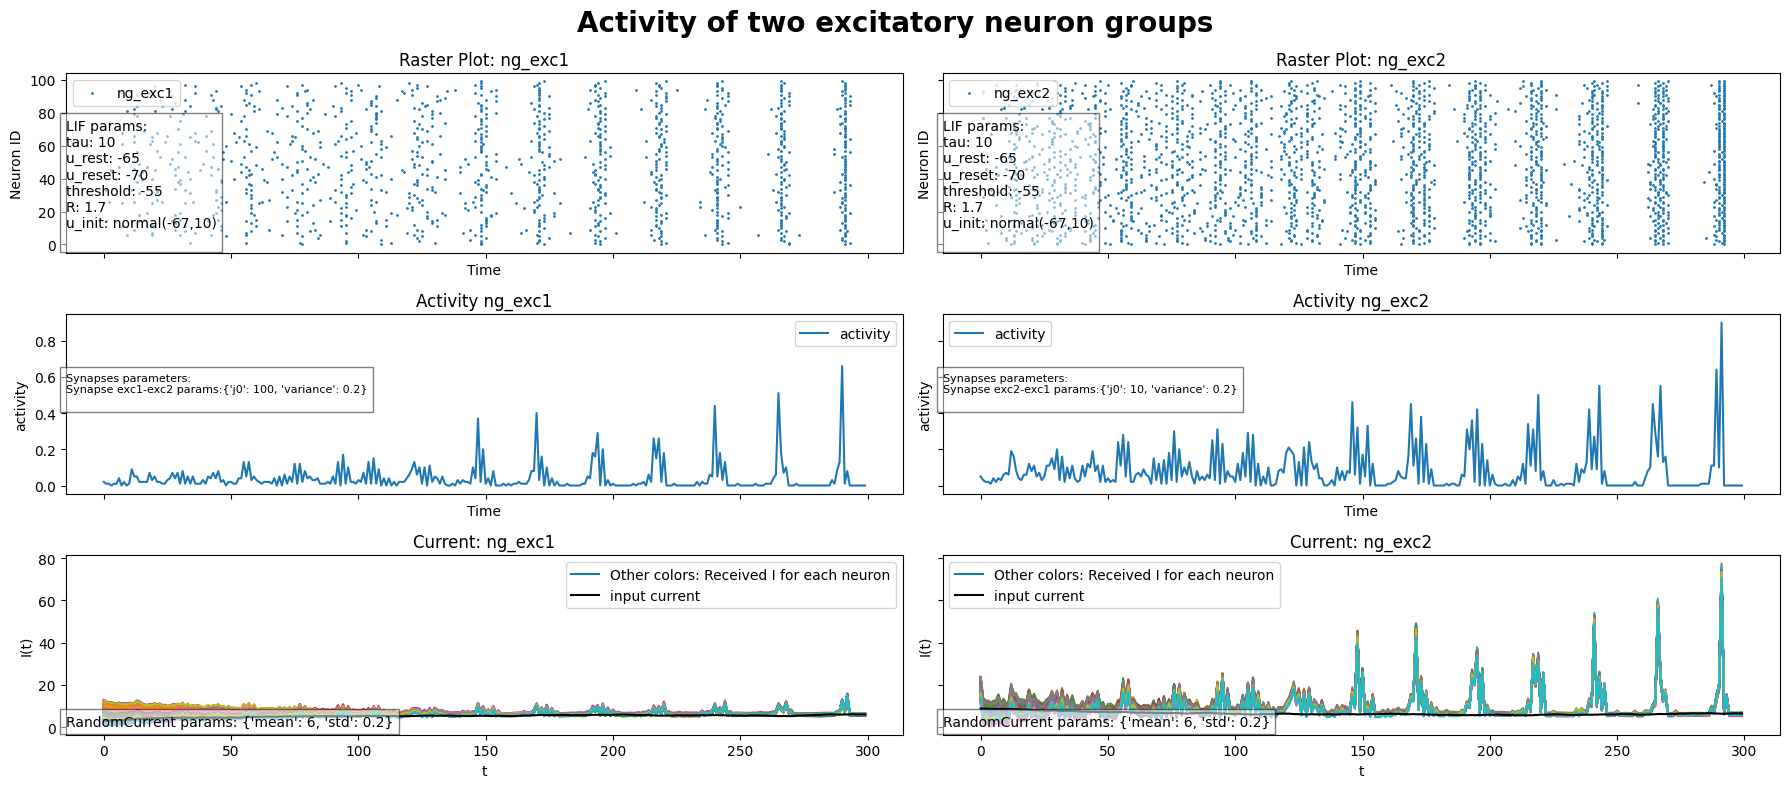

In [36]:
fig, axs = plt.subplots(3, 2, figsize=(18, 8), sharex=True, sharey='row')
# Raster plot for ng1:
ng_exc1.add_raster_plot(axs[0, 0], s=1)
ng_exc1.add_neuron_model_params_info(axs[0, 0], model_idx=7)
# Raster plot for ng2:
ng_exc2.add_raster_plot(axs[0, 1], s=1)
ng_exc2.add_neuron_model_params_info(axs[0, 1], model_idx=7)

# Activity plot for ng1:
ng_exc1.add_activity_plot(axs[1, 0])
syn_exc1_exc2.add_synapses_params_info(axs[1, 0], synapse_idx=3)
# Activity plot for ng2:
ng_exc2.add_activity_plot(axs[1, 1])
syn_exc2_exc1.add_synapses_params_info(axs[1, 1], synapse_idx=3)

# Current plot for ng1:
ng_exc1.add_current_plot(axs[2, 0])
ng_exc2.add_current_params_info(axs[2, 0], current_idx=2)
# Current plot for ng2:
ng_exc2.add_current_plot(axs[2, 1])
ng_exc2.add_current_params_info(axs[2, 1], current_idx=2)


fig.suptitle("Activity of two excitatory neuron groups", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-two-ng-full-synapse-diff-j-rand-curr.pdf")
plt.show()

#### Change variance

noisy curr

In [56]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc1 = sim.add_neuron_group(
    tag="ng_exc1",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.5),
        # 2: RandomCurrent(mean=6, sts=0.2),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc1_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc1_event")
    }
)
ng_exc2 = sim.add_neuron_group(
    tag="ng_exc2",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.5),
        # 2: RandomCurrent(mean=6, sts=0.2),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc2_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc2_event")
    }
)
syn_exc1_exc2 = sim.add_synapse_group(
                   tag="exc1-exc2",
                   src=ng_exc1,
                   dst=ng_exc2,
                   behavior={3: FullyConnectedSynapse(j0=10, variance=0.9)})

syn_exc2_exc1 = sim.add_synapse_group(
                   tag="exc2-exc1",
                   src=ng_exc2,
                   dst=ng_exc1,
                   behavior={3: FullyConnectedSynapse(j0=10, variance=0.9)})
sim.simulate(iterations=300)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(20000)|2 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc1', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.5,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_event,)}
NeuronGroup['ng_exc2', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.5,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annot

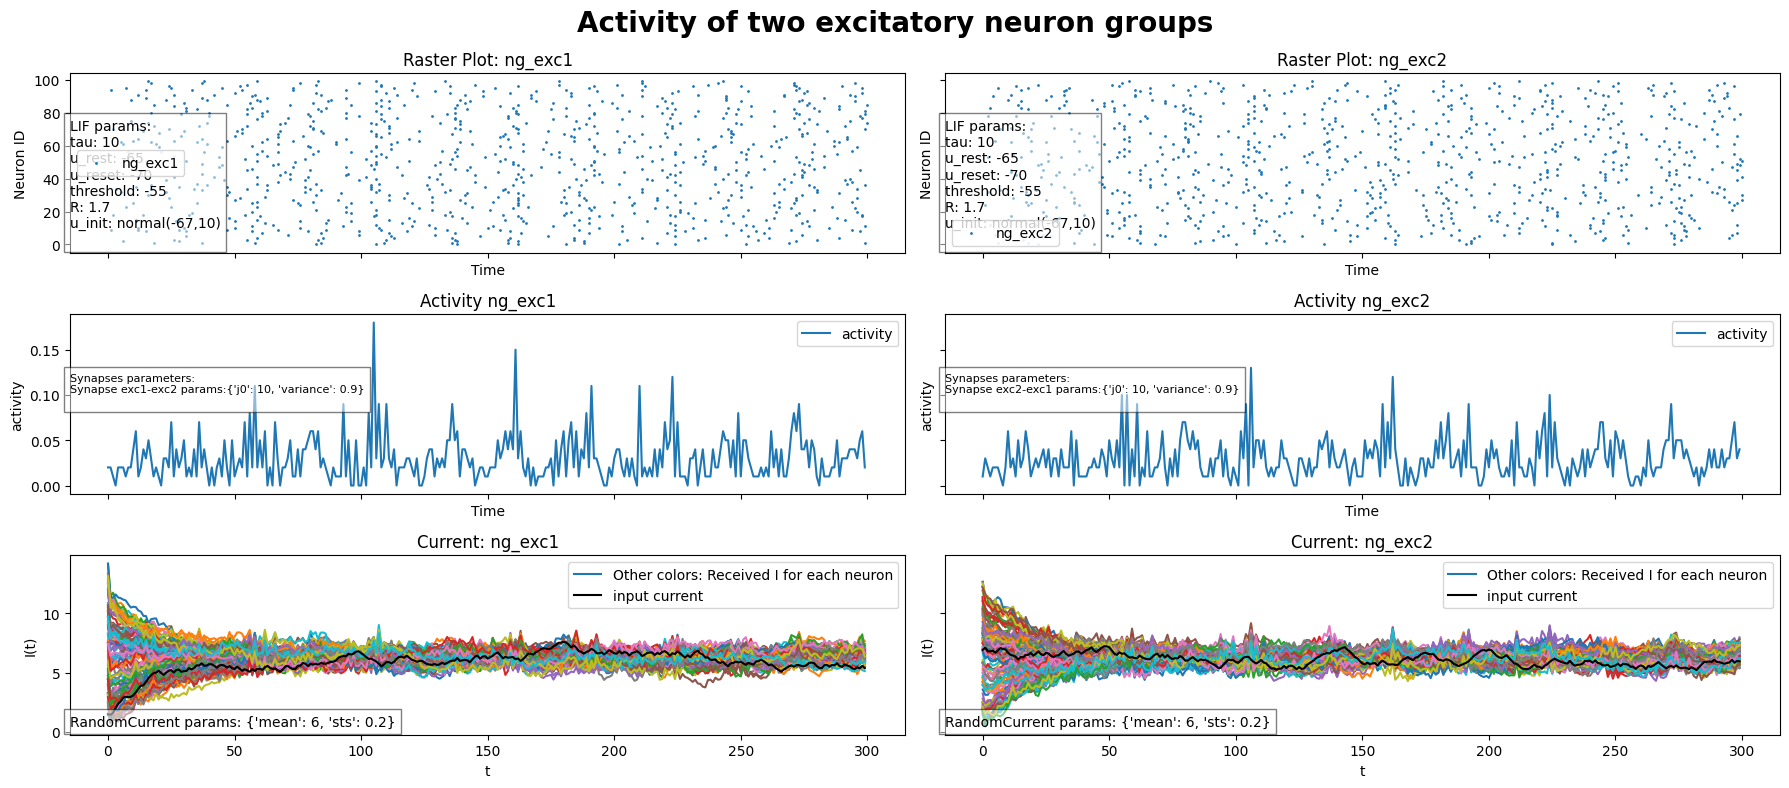

In [60]:
fig, axs = plt.subplots(3, 2, figsize=(18, 8), sharex=True, sharey='row')
# Raster plot for ng1:
ng_exc1.add_raster_plot(axs[0, 0], s=1)
ng_exc1.add_neuron_model_params_info(axs[0, 0], model_idx=7)
# Raster plot for ng2:
ng_exc2.add_raster_plot(axs[0, 1], s=1)
ng_exc2.add_neuron_model_params_info(axs[0, 1], model_idx=7)

# Activity plot for ng1:
ng_exc1.add_activity_plot(axs[1, 0])
syn_exc1_exc2.add_synapses_params_info(axs[1, 0], synapse_idx=3)
# Activity plot for ng2:
ng_exc2.add_activity_plot(axs[1, 1])
syn_exc2_exc1.add_synapses_params_info(axs[1, 1], synapse_idx=3)

# Current plot for ng1:
ng_exc1.add_current_plot(axs[2, 0])
ng_exc2.add_current_params_info(axs[2, 0], current_idx=2)
# Current plot for ng2:
ng_exc2.add_current_plot(axs[2, 1])
ng_exc2.add_current_params_info(axs[2, 1], current_idx=2)


fig.suptitle("Activity of two excitatory neuron groups", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-two-ng-full-synapse-high-variance-noise-curr.pdf")
plt.show()

In [61]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc1 = sim.add_neuron_group(
    tag="ng_exc1",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        # 2: ConstantCurrent(value=6, noise_range=0.5),
        2: RandomCurrent(mean=6, sts=0.2),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc1_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc1_event")
    }
)
ng_exc2 = sim.add_neuron_group(
    tag="ng_exc2",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        # 2: ConstantCurrent(value=6, noise_range=0.5),
        2: RandomCurrent(mean=6, sts=0.2),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc2_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc2_event")
    }
)
syn_exc1_exc2 = sim.add_synapse_group(
                   tag="exc1-exc2",
                   src=ng_exc1,
                   dst=ng_exc2,
                   behavior={3: FullyConnectedSynapse(j0=10, variance=0.9)})

syn_exc2_exc1 = sim.add_synapse_group(
                   tag="exc2-exc1",
                   src=ng_exc2,
                   dst=ng_exc1,
                   behavior={3: FullyConnectedSynapse(j0=10, variance=0.9)})
sim.simulate(iterations=300)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(20000)|2 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc1', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:RandomCurrent(mean=6,sts=0.2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_event,)}
NeuronGroup['ng_exc2', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:RandomCurrent(mean=6,sts=0.2,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_e

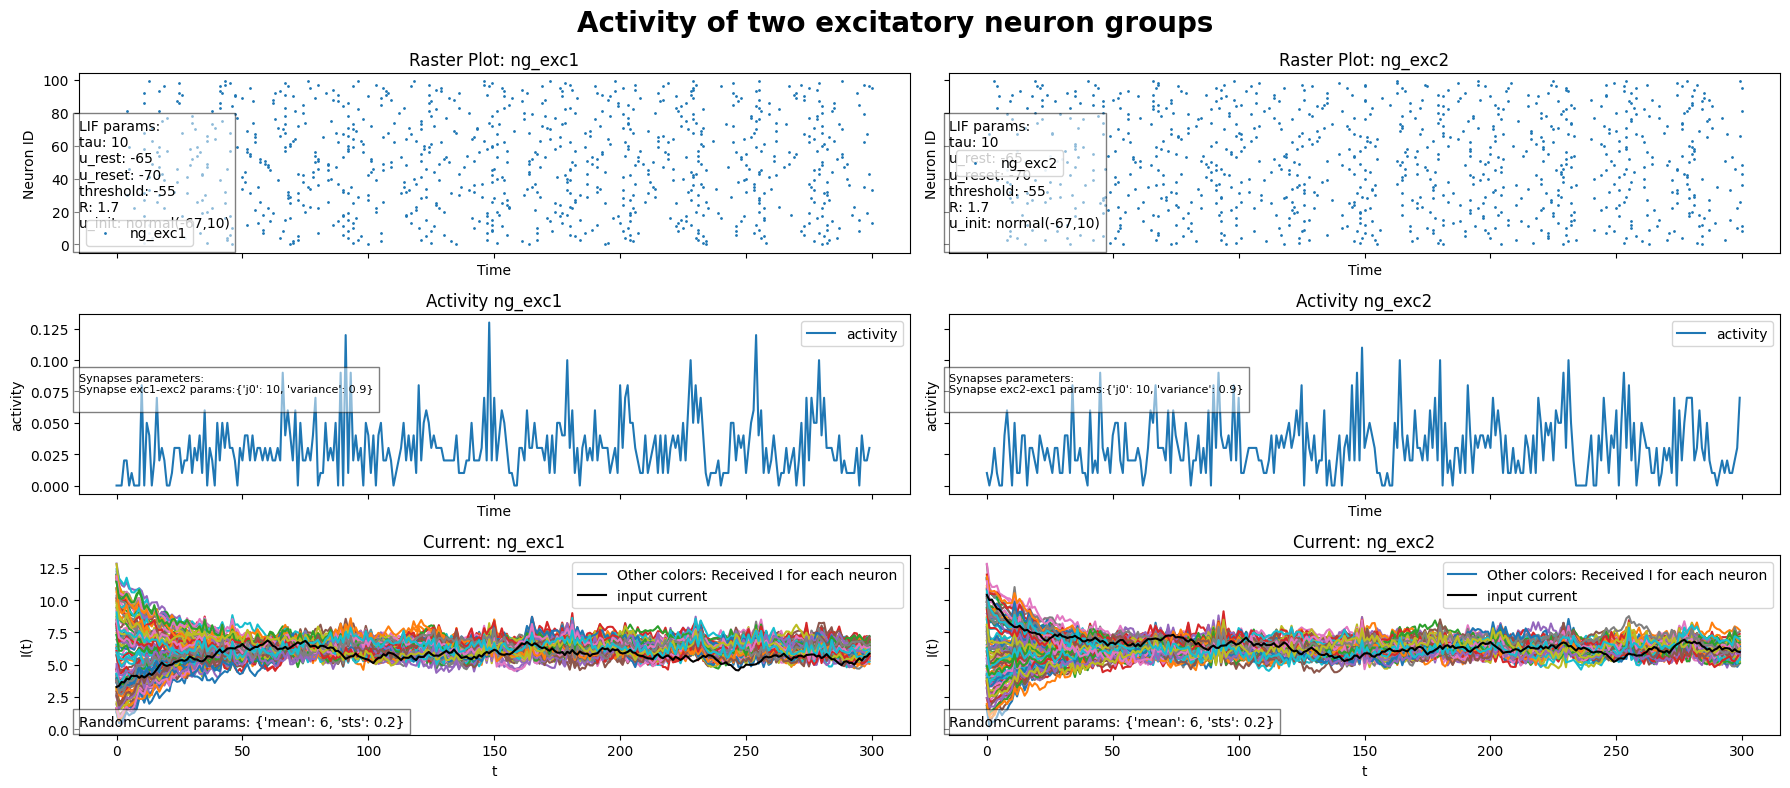

In [62]:
fig, axs = plt.subplots(3, 2, figsize=(18, 8), sharex=True, sharey='row')
# Raster plot for ng1:
ng_exc1.add_raster_plot(axs[0, 0], s=1)
ng_exc1.add_neuron_model_params_info(axs[0, 0], model_idx=7)
# Raster plot for ng2:
ng_exc2.add_raster_plot(axs[0, 1], s=1)
ng_exc2.add_neuron_model_params_info(axs[0, 1], model_idx=7)

# Activity plot for ng1:
ng_exc1.add_activity_plot(axs[1, 0])
syn_exc1_exc2.add_synapses_params_info(axs[1, 0], synapse_idx=3)
# Activity plot for ng2:
ng_exc2.add_activity_plot(axs[1, 1])
syn_exc2_exc1.add_synapses_params_info(axs[1, 1], synapse_idx=3)

# Current plot for ng1:
ng_exc1.add_current_plot(axs[2, 0])
ng_exc2.add_current_params_info(axs[2, 0], current_idx=2)
# Current plot for ng2:
ng_exc2.add_current_plot(axs[2, 1])
ng_exc2.add_current_params_info(axs[2, 1], current_idx=2)


fig.suptitle("Activity of two excitatory neuron groups", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-two-ng-full-synapse-high-variance-rand-curr.pdf")
plt.show()

Different variance

In [69]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc1 = sim.add_neuron_group(
    tag="ng_exc1",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.5),
        # 2: RandomCurrent(mean=6, sts=0.2),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc1_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc1_event")
    }
)
ng_exc2 = sim.add_neuron_group(
    tag="ng_exc2",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.5),
        # 2: RandomCurrent(mean=6, sts=0.2),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc2_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc2_event")
    }
)
syn_exc1_exc2 = sim.add_synapse_group(
                   tag="exc1-exc2",
                   src=ng_exc1,
                   dst=ng_exc2,
                   behavior={3: FullyConnectedSynapse(j0=10, variance=0.1)})

syn_exc2_exc1 = sim.add_synapse_group(
                   tag="exc2-exc1",
                   src=ng_exc2,
                   dst=ng_exc1,
                   behavior={3: FullyConnectedSynapse(j0=10, variance=0.9)})
sim.simulate(iterations=300)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(20000)|2 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc1', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.5,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_event,)}
NeuronGroup['ng_exc2', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.5,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annot

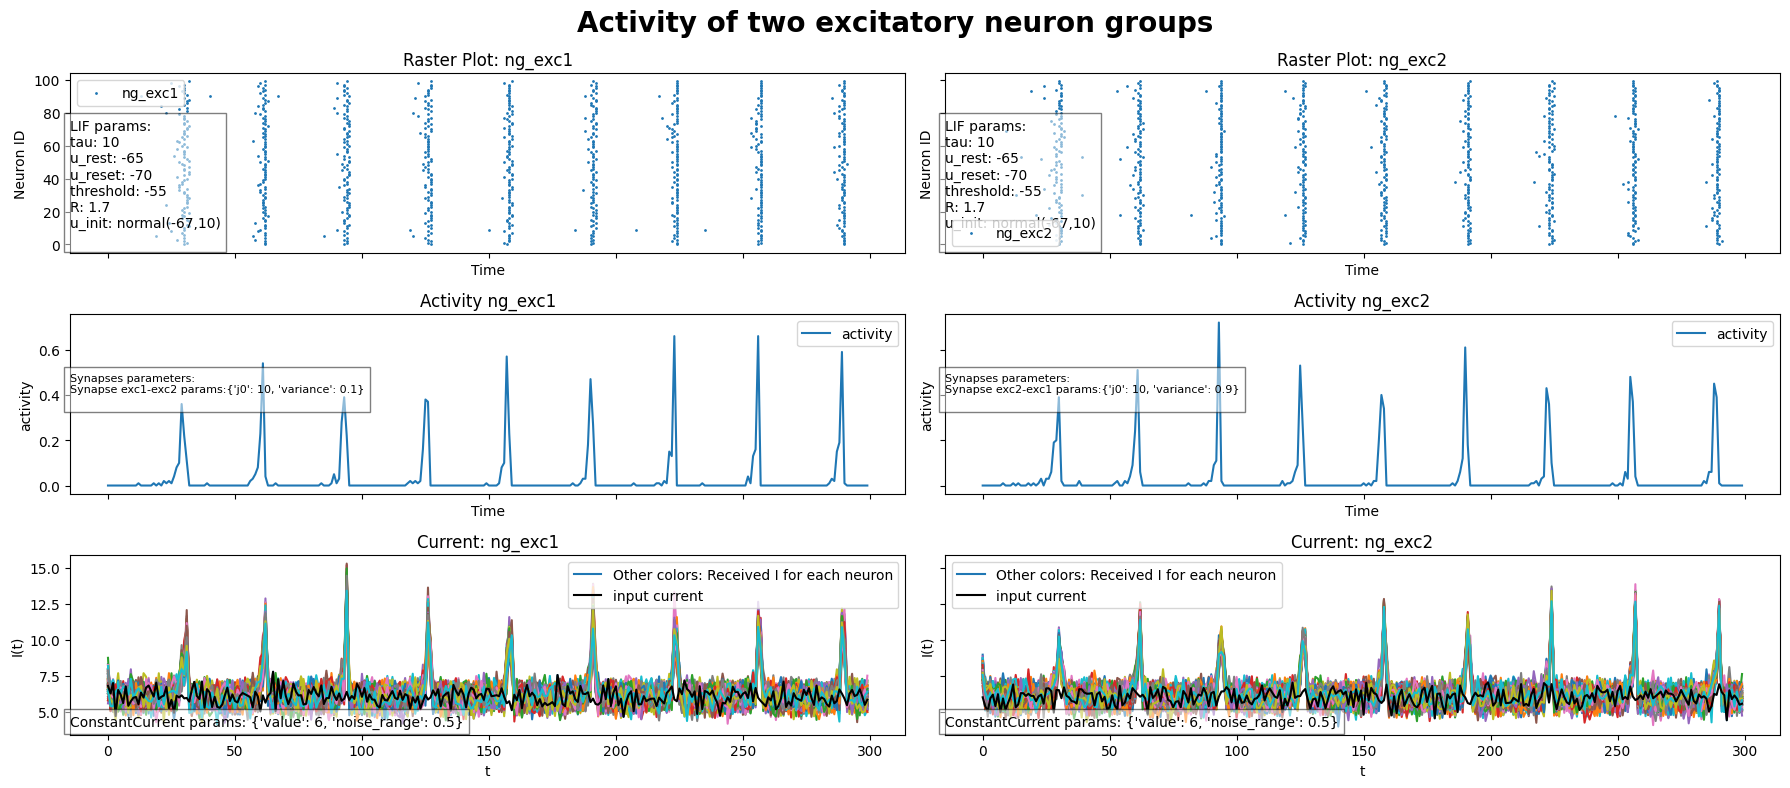

In [70]:
fig, axs = plt.subplots(3, 2, figsize=(18, 8), sharex=True, sharey='row')
# Raster plot for ng1:
ng_exc1.add_raster_plot(axs[0, 0], s=1)
ng_exc1.add_neuron_model_params_info(axs[0, 0], model_idx=7)
# Raster plot for ng2:
ng_exc2.add_raster_plot(axs[0, 1], s=1)
ng_exc2.add_neuron_model_params_info(axs[0, 1], model_idx=7)

# Activity plot for ng1:
ng_exc1.add_activity_plot(axs[1, 0])
syn_exc1_exc2.add_synapses_params_info(axs[1, 0], synapse_idx=3)
# Activity plot for ng2:
ng_exc2.add_activity_plot(axs[1, 1])
syn_exc2_exc1.add_synapses_params_info(axs[1, 1], synapse_idx=3)

# Current plot for ng1:
ng_exc1.add_current_plot(axs[2, 0])
ng_exc2.add_current_params_info(axs[2, 0], current_idx=2)
# Current plot for ng2:
ng_exc2.add_current_plot(axs[2, 1])
ng_exc2.add_current_params_info(axs[2, 1], current_idx=2)


fig.suptitle("Activity of two excitatory neuron groups", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-two-ng-full-synapse-diff-variance-noise-curr.pdf")
plt.show()

In [71]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc1 = sim.add_neuron_group(
    tag="ng_exc1",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.5),
        # 2: RandomCurrent(mean=6, sts=0.2),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc1_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc1_event")
    }
)
ng_exc2 = sim.add_neuron_group(
    tag="ng_exc2",
    size=100,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.5),
        # 2: RandomCurrent(mean=6, sts=0.2),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc2_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc2_event")
    }
)
syn_exc1_exc2 = sim.add_synapse_group(
                   tag="exc1-exc2",
                   src=ng_exc1,
                   dst=ng_exc2,
                   behavior={3: FullyConnectedSynapse(j0=10, variance=100)})

syn_exc2_exc1 = sim.add_synapse_group(
                   tag="exc2-exc1",
                   src=ng_exc2,
                   dst=ng_exc1,
                   behavior={3: FullyConnectedSynapse(j0=10, variance=0.9)})
sim.simulate(iterations=300)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(20000)|2 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc1', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.5,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_event,)}
NeuronGroup['ng_exc2', 'CustomNeuronGroup', 'ng'](100){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.5,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annot

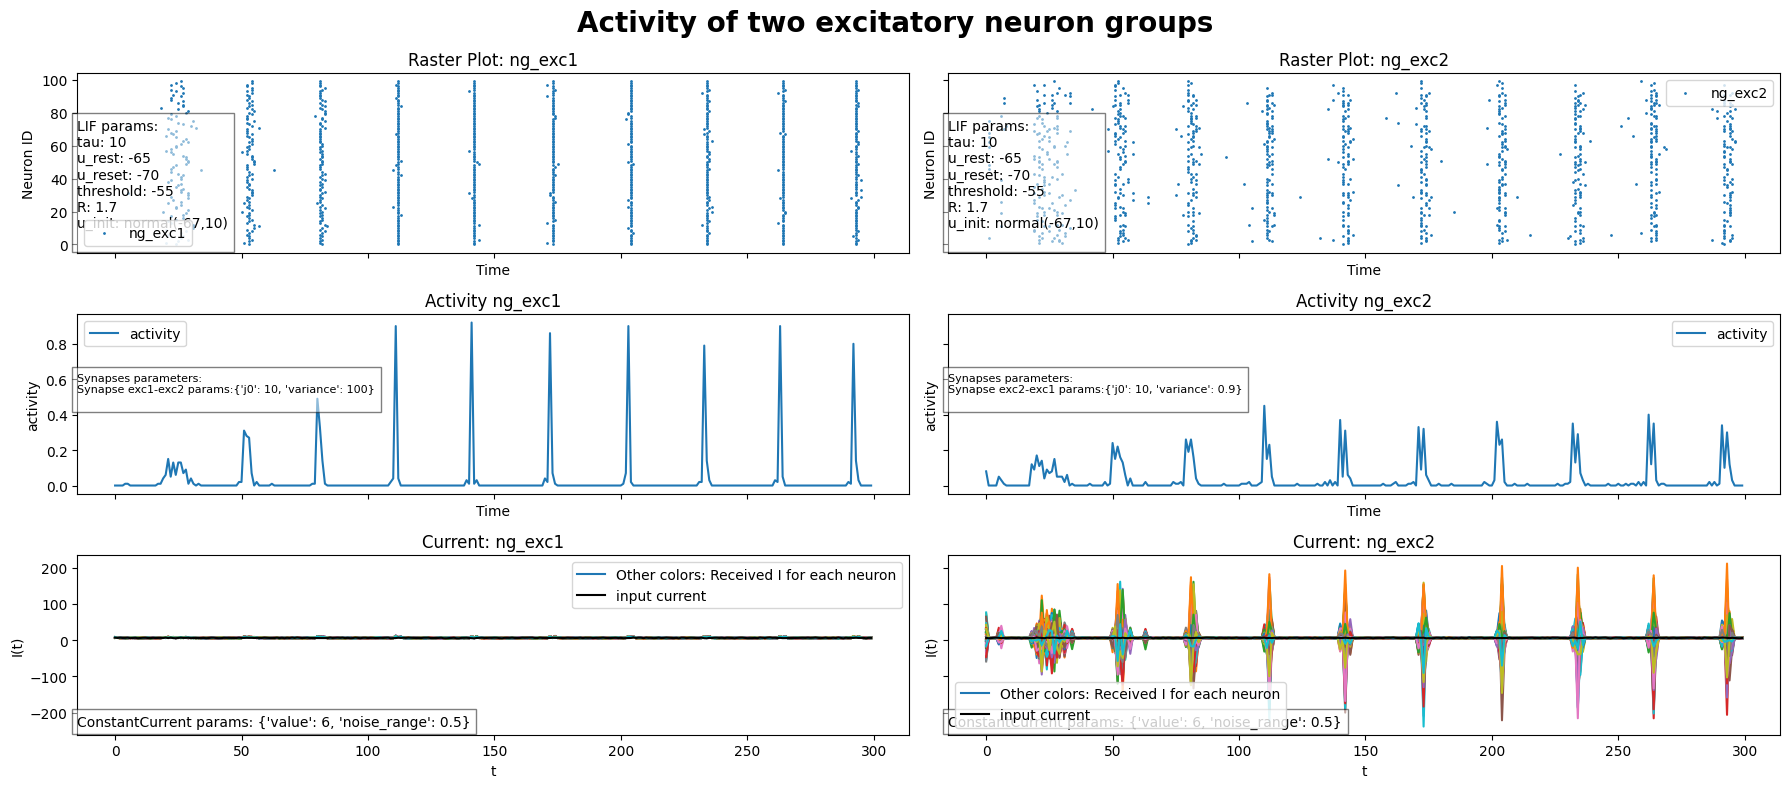

In [72]:
fig, axs = plt.subplots(3, 2, figsize=(18, 8), sharex=True, sharey='row')
# Raster plot for ng1:
ng_exc1.add_raster_plot(axs[0, 0], s=1)
ng_exc1.add_neuron_model_params_info(axs[0, 0], model_idx=7)
# Raster plot for ng2:
ng_exc2.add_raster_plot(axs[0, 1], s=1)
ng_exc2.add_neuron_model_params_info(axs[0, 1], model_idx=7)

# Activity plot for ng1:
ng_exc1.add_activity_plot(axs[1, 0])
syn_exc1_exc2.add_synapses_params_info(axs[1, 0], synapse_idx=3)
# Activity plot for ng2:
ng_exc2.add_activity_plot(axs[1, 1])
syn_exc2_exc1.add_synapses_params_info(axs[1, 1], synapse_idx=3)

# Current plot for ng1:
ng_exc1.add_current_plot(axs[2, 0])
ng_exc2.add_current_params_info(axs[2, 0], current_idx=2)
# Current plot for ng2:
ng_exc2.add_current_plot(axs[2, 1])
ng_exc2.add_current_params_info(axs[2, 1], current_idx=2)


fig.suptitle("Activity of two excitatory neuron groups", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-two-ng-full-synapse-very-high-variance-noise-curr.pdf")
plt.show()

#### Change in size

In [81]:
sim = Simulation(net=Network(behavior={1: TimeResolution(dt=1.0,)}),)
ng_exc1 = sim.add_neuron_group(
    tag="ng_exc1",
    size=250,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.6),
        # 2: RandomCurrent(mean=6, sts=0.2),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc1_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc1_event")
    }
)
ng_exc2 = sim.add_neuron_group(
    tag="ng_exc2",
    size=50,
    behavior={
        1: SetCurrent(value=0),
        2: ConstantCurrent(value=6, noise_range=0.6),
        # 2: RandomCurrent(mean=6, sts=0.2),

        6: Dendrite(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-55,
            R=1.7,
            u_init="normal(-67,10)"
        ),
        8: ActivityRecorder(),
        9: Recorder(variables=["u", "I", "inp_I", "activity"], tag="ng_exc2_rec"),
        10: EventRecorder(variables=['spike'], tag="ng_exc2_event")
    }
)
syn_exc1_exc2 = sim.add_synapse_group(
                   tag="exc1-exc2",
                   src=ng_exc1,
                   dst=ng_exc2,
                   behavior={3: FullyConnectedSynapse(j0=10, variance=0.5)})

syn_exc2_exc1 = sim.add_synapse_group(
                   tag="exc2-exc1",
                   src=ng_exc2,
                   dst=ng_exc1,
                   behavior={3: FullyConnectedSynapse(j0=10, variance=0.5)})
sim.simulate(iterations=300)

Network['Network_1', 'Network'](Neurons: tensor(300)|2 groups, Synapses: tensor(25000)|2 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['ng_exc1', 'CustomNeuronGroup', 'ng'](250){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.6,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc1_event,)}
NeuronGroup['ng_exc2', 'CustomNeuronGroup', 'ng'](50){1:SetCurrent(value=0,)2:ConstantCurrent(value=6,noise_range=0.6,)6:Dendrite()7:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-55,R=1.7,u_init=normal(-67,10),)8:ActivityRecorder()9:Recorder(variables=['u', 'I', 'inp_I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng_exc2_rec,)10:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annota

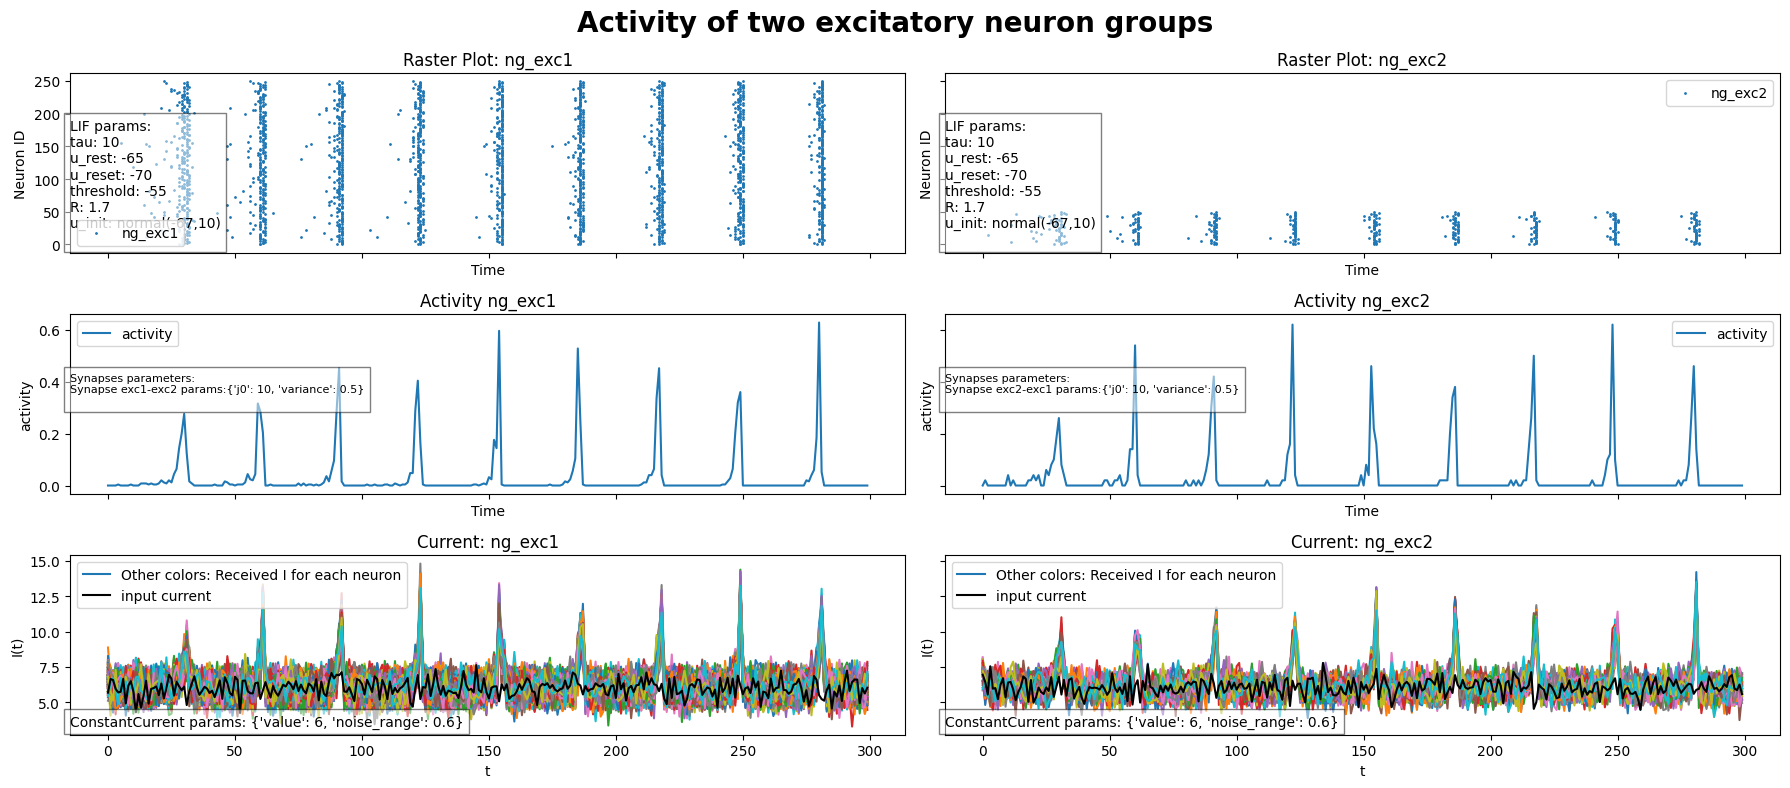

In [82]:
fig, axs = plt.subplots(3, 2, figsize=(18, 8), sharex=True, sharey='row')
# Raster plot for ng1:
ng_exc1.add_raster_plot(axs[0, 0], s=1)
ng_exc1.add_neuron_model_params_info(axs[0, 0], model_idx=7)
# Raster plot for ng2:
ng_exc2.add_raster_plot(axs[0, 1], s=1)
ng_exc2.add_neuron_model_params_info(axs[0, 1], model_idx=7)

# Activity plot for ng1:
ng_exc1.add_activity_plot(axs[1, 0])
syn_exc1_exc2.add_synapses_params_info(axs[1, 0], synapse_idx=3)
# Activity plot for ng2:
ng_exc2.add_activity_plot(axs[1, 1])
syn_exc2_exc1.add_synapses_params_info(axs[1, 1], synapse_idx=3)

# Current plot for ng1:
ng_exc1.add_current_plot(axs[2, 0])
ng_exc2.add_current_params_info(axs[2, 0], current_idx=2)
# Current plot for ng2:
ng_exc2.add_current_plot(axs[2, 1])
ng_exc2.add_current_params_info(axs[2, 1], current_idx=2)


fig.suptitle("Activity of two excitatory neuron groups", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part2-two-ng-full-synapse-diff-size-noise-curr.pdf")
plt.show()